<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exericse_and_Extra-curriculum/%F0%9F%9B%A0_06_Transfer_Learning_in_TensorFlow_Part_3_Scaling_up_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercise Solutions 


1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

2. Recreate the first model (the feature extraction model) with mixed_precision turned on.
  - Does it make the model train faster?
  - Does it effect the accuracy or performance of our model?
  - What's the advatanges of using mixed_precision training?
  
3. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁 . 

## Getting the data and a model readdy

In [1]:
# Getting the helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

--2021-07-06 17:54:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-06 17:54:53 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2021-07-06 17:54:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [2]:
# Importing the packages we need 
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation layers for our model 
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomZoom(0.2)
], name="data_augmentation_layers")


In [3]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# Building a model to compare with 
base_model_0 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_0.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = data_augmentation(inputs)
x = base_model_0(x , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
model_0 = tf.keras.Model(inputs , outputs , name = 'model_0')
model_0.summary()

16711680/16705208 [==============================] - 1s 0us/step
Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layers (Se (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [6]:
# Compiling the model
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_model_0 = model_0.fit(train_data_all_10_percent,
                                           epochs=5, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5
237/237 [==============================] - 119s 355ms/step - loss: 3.4782 - accuracy: 0.2448 - val_loss: 2.6204 - val_accuracy: 0.4327
Epoch 2/5
237/237 [==============================] - 72s 303ms/step - loss: 2.3612 - accuracy: 0.4630 - val_loss: 2.1961 - val_accuracy: 0.4807
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.9823 - accuracy: 0.5234 - val_loss: 2.0820 - val_accuracy: 0.4865
Epoch 4/5
237/237 [==============================] - 61s 255ms/step - loss: 1.7506 - accuracy: 0.5753 - val_loss: 1.9735 - val_accuracy: 0.5074
Epoch 5/5
237/237 [==============================] - 59s 246ms/step - loss: 1.6103 - accuracy: 0.6020 - val_loss: 1.9779 - val_accuracy: 0.4960


In [7]:
# Evaluating the model 
results_feature_extraction_model_0 = model_0.evaluate(test_data)
results_feature_extraction_model_0

790/790 [==============================] - 87s 110ms/step - loss: 1.7216 - accuracy: 0.5519


[1.721637487411499, 0.5518811941146851]

In [8]:
# Fine tuning the model (unfreezing all the layer and refreezing everything excpet the last 7 layer)
base_model_0.trainable = True 

# Refreeze every layer except for the last 7 
for layer in base_model_0.layers[:-7]:
  layer.trainable = False

In [9]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_0.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [11]:
# Recompiling the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001 / 10) , 
                metrics = ['accuracy'])

In [13]:
# Fine-tune for 5 more epochs
initial_epochs = 5
fine_tune_epochs = 5 + initial_epochs # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_model_0_fine_tune = model_0.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_model_0.epoch[-1]) 

Epoch 5/10
237/237 [==============================] - 64s 242ms/step - loss: 1.3512 - accuracy: 0.6453 - val_loss: 1.9031 - val_accuracy: 0.5077
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.2239 - accuracy: 0.6783 - val_loss: 1.8953 - val_accuracy: 0.5087
Epoch 7/10
237/237 [==============================] - 53s 222ms/step - loss: 1.1361 - accuracy: 0.7024 - val_loss: 1.8775 - val_accuracy: 0.5159
Epoch 8/10
237/237 [==============================] - 50s 211ms/step - loss: 1.0790 - accuracy: 0.7134 - val_loss: 1.9244 - val_accuracy: 0.5109
Epoch 9/10
237/237 [==============================] - 51s 213ms/step - loss: 1.0010 - accuracy: 0.7387 - val_loss: 1.9029 - val_accuracy: 0.5130
Epoch 10/10
237/237 [==============================] - 49s 206ms/step - loss: 0.9460 - accuracy: 0.7534 - val_loss: 1.9318 - val_accuracy: 0.5069


In [14]:
# Evaluating the model results 

results_fine_tune_model_0 = model_0.evaluate(test_data)
results_fine_tune_model_0

790/790 [==============================] - 86s 109ms/step - loss: 1.6481 - accuracy: 0.5721


[1.648119330406189, 0.5720791816711426]

Alright now we got a model to compare, let's begin our exercise! 

### 1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [15]:
# Building the feature extractor model
base_model_1 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_1.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = data_augmentation(inputs)
x = base_model_1(x , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
feature_extractor_model = tf.keras.Model(inputs , outputs , name = 'feature_extractor_model')
feature_extractor_model.summary() 

Model: "feature_extractor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layers (Se (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
# Compiling the feature extractor model 
feature_extractor_model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                                optimizer = tf.keras.optimizers.Adam() , 
                                metrics = ['accuracy'])

# Fitting the feature extractor model for 10 epochs
history_feature_extractor_model = feature_extractor_model.fit(train_data_all_10_percent,
                                           epochs=10, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data))) 

Epoch 1/10
237/237 [==============================] - 55s 212ms/step - loss: 3.4691 - accuracy: 0.2475 - val_loss: 2.6074 - val_accuracy: 0.4266
Epoch 2/10
237/237 [==============================] - 47s 195ms/step - loss: 2.3517 - accuracy: 0.4642 - val_loss: 2.1900 - val_accuracy: 0.4711
Epoch 3/10
237/237 [==============================] - 47s 198ms/step - loss: 1.9911 - accuracy: 0.5265 - val_loss: 2.0189 - val_accuracy: 0.4923
Epoch 4/10
237/237 [==============================] - 46s 193ms/step - loss: 1.7686 - accuracy: 0.5745 - val_loss: 1.9980 - val_accuracy: 0.4886
Epoch 5/10
237/237 [==============================] - 45s 188ms/step - loss: 1.6129 - accuracy: 0.6042 - val_loss: 1.8922 - val_accuracy: 0.5085
Epoch 6/10
237/237 [==============================] - 46s 193ms/step - loss: 1.4766 - accuracy: 0.6364 - val_loss: 1.8988 - val_accuracy: 0.5034
Epoch 7/10
237/237 [==============================] - 44s 186ms/step - loss: 1.3866 - accuracy: 0.6533 - val_loss: 1.8773 - val_ac

In [17]:
# Evaluating the feature extractor model on test data 
feature_extractor_results = feature_extractor_model.evaluate(test_data)
feature_extractor_results 

790/790 [==============================] - 87s 110ms/step - loss: 1.6382 - accuracy: 0.5662


[1.6382192373275757, 0.566217839717865]

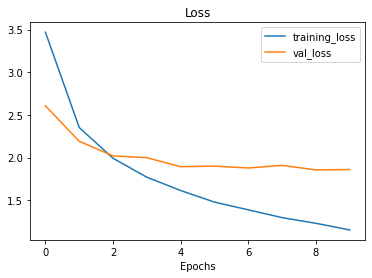

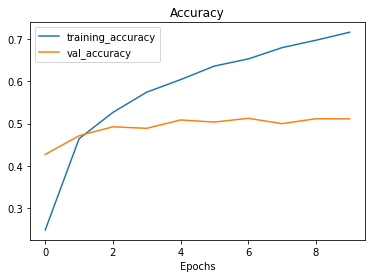

In [20]:
plot_loss_curves(history_feature_extractor_model)

In [ ]:
plot_loss_curves(history_model_0_fine_tune)